In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0716 20:37:48.941216 4638555584 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



In [2]:
import scipy

# Get Fashion MNIST Data

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

In [5]:
#One hot the labels
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
x_train_master, y_train_master = x_train[:30000], y_train[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train[30000:]

In [7]:
#Flatten everything
x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
x_train_slave_flat, _ = flatten_mnist(x_train_slave)
x_test_flat, _  = flatten_mnist(x_test)

In [12]:
x_big = np.vstack((x_train_master_flat, x_test_flat))

In [13]:
U, sigma_lst, _ = scipy.linalg.svd(x_big, full_matrices = False)

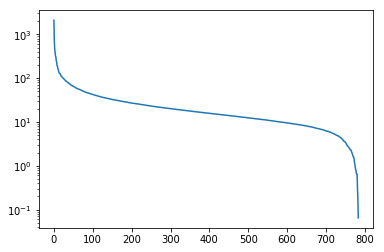

In [18]:
plt.plot(np.arange(784), sigma_lst)
plt.yscale('log')

In [57]:
x_big_orth = U
mn = np.percentile(np.abs(x_big_orth.flatten()), 95)
x_big_orth = x_big_orth/mn

In [63]:
x_train_master_flat_ogi = x_big_orth[:30000]
x_test_flat_ogi = x_big_orth[30000:]

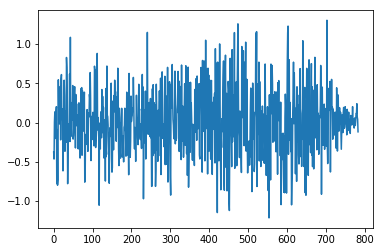

In [64]:
plt.plot(np.arange(784), x_train_master_flat[3])

In [70]:
input_shape

(784,)

# Train Master

In [71]:
def train_with_num_columns(num_cols): 
    input_shape = (num_cols, )
    x_train_master_flat = x_train_master_flat_ogi[:, :num_cols]
    x_test_flat = x_test_flat_ogi[:, :num_cols]
    
    #Configurations
    eps_train = 0.1                                                                                                                            
    eps_test = 0.01                                                                                                                            
    tensorboard_dir = "../tb/"                                                                                                                
    weights_dir = "../weights/"                                                                                                               
    load_weights = False                                                                                                              
    load_counter = 234                                                                                                            
    sigma = tf.nn.relu                                                                                                                         
    epochs, reg, lr = 10, 0.00, 1e-3    
    #epochs, reg, lr = 30, 0.00, 15e-4                                                                                                          
    pgd_eta, pgd_num_iter = 5000, 200

    #Setup - Dataset stuff
    tf.reset_default_graph()
    sess = tf.Session()
    hidden_sizes = [64, 64, 32]
    dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

    scope_name = "teacher_student_fashion"
    if not load_weights:
        with tf.variable_scope(scope_name, reuse = False) as scope:

            logdir = tensorboard_dir + str(counter)

            #Create model
            writer = tf.summary.FileWriter(logdir)
            model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
            sess.run(tf.global_variables_initializer())
            print("Created model successfully. Now going to train")

            #Train model
            model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)

            """
            #Save weights
            weights = tf.trainable_variables()
            #weights = model.get_weights()[0] + model.get_weights()[1]
            saver = tf.train.Saver(weights)
            weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
            print("Saved model at %s"%weights_path)
            """

            #Test model - regular, fgsm adv, pgd adv
            loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            print("----Regular test accuracy and loss ----")
            print((loss_reg, acc_reg))

            loss_fgsm, acc_fgsm, _ = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            print("----FGSM test accuracy and loss ----")
            print((loss_fgsm, acc_fgsm))

            loss_pgd, acc_pgd, deltas = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
            print("----PGD test accuracy and loss ----")
            print((loss_pgd , acc_pgd))
            
    return loss_reg, acc_reg, loss_fgsm, acc_fgsm, loss_pgd, acc_pgd

In [73]:
num_cols_lst = [784, 680, 520, 400, 300, 200, 100, 50]
lr_lst, ar_lst, lf_lst, af_lst, lp_lst, ap_lst = [], [], [], [], [], []

for nc in num_cols_lst:
    lr, ar, lf, af, lp, ap = train_with_num_columns(nc)
    lr_lst.append(lr)
    ar_lst.append(ar)
    lf_lst.append(lf)
    af_lst.append(af)
    lp_lst.append(lp)
    ap_lst.append(ap)


Initialized instance variables of the robust model class
I0716 21:17:32.015621 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:17:32.024624 4638555584 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 21:17:32.104386 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:17:32.111124 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 21:17:32.140504 4638555584 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 21:17:32.144556 4638555584 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.973671439 
I0716 21:17:33.896080 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.973671439 
Accuracy on batch: 0.812500
I0716 21:17:33.897349 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.812500
Epoch: 0002    cost: 0.384648623 
I0716 21:17:35.074146 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.384648623 
Accuracy on batch: 0.843750
I0716 21:17:35.075943 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0003    cost: 0.274344434 
I0716 21:17:36.187093 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.274344434 
Accuracy on batch: 0.843750
I0716 21:17:36.188114 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0004    cost: 0.208684982 
I0716 21:17:37.215728 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.208684982 
Accuracy on batch: 0.906250
I0716 21:17:37.216752 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.906250
Epoch: 0005    cost: 0.1

----Regular test accuracy and loss ----
(1.1549809, 0.8097)


Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations
I0716 21:17:43.887728 4638555584 feedforward_robust.py:684] Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations


----FGSM test accuracy and loss ----
(3.3318617, 0.4249)
iteration: 0
loss 3.155272
iteration: 20
loss 4.436076
iteration: 40
loss 4.436352
iteration: 60
loss 4.436481
iteration: 80
loss 4.436224
iteration: 100
loss 4.436434
iteration: 120
loss 4.436435
iteration: 140
loss 4.436194
iteration: 160
loss 4.436399
iteration: 180
loss 4.436485


This is to confirm that attack does not violate constraints
I0716 21:18:08.398188 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:18:08.399273 4638555584 feedforward_robust.py:530] Should be no more than eps
30.0624895241944
I0716 21:18:08.444062 4638555584 feedforward_robust.py:531] 30.0624895241944
Initialized instance variables of the robust model class
I0716 21:18:08.563720 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:18:08.570734 4638555584 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 21:18:08.647791 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:18:08.658123 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to th

----PGD test accuracy and loss ----
(4.43859, 0.3259)
Created model successfully. Now going to train


Epoch: 0001    cost: 0.925906796 
I0716 21:18:10.474848 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.925906796 
Accuracy on batch: 0.781250
I0716 21:18:10.476016 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.781250
Epoch: 0002    cost: 0.374563187 
I0716 21:18:11.416321 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.374563187 
Accuracy on batch: 0.812500
I0716 21:18:11.417373 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.812500
Epoch: 0003    cost: 0.278769807 
I0716 21:18:12.424586 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.278769807 
Accuracy on batch: 0.843750
I0716 21:18:12.425988 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0004    cost: 0.223832155 
I0716 21:18:13.400833 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.223832155 
Accuracy on batch: 0.875000
I0716 21:18:13.401875 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0005    cost: 0.1

----Regular test accuracy and loss ----
(1.1697599, 0.8136)


Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations
I0716 21:18:19.688698 4638555584 feedforward_robust.py:684] Model is being evaluated on PGD points generated using 5000.000000 learning rate and 200 iterations


----FGSM test accuracy and loss ----
(4.567066, 0.3833)
iteration: 0
loss 4.373612
iteration: 20
loss 5.711520
iteration: 40
loss 5.711796
iteration: 60
loss 5.711728
iteration: 80
loss 5.711637
iteration: 100
loss 5.711799
iteration: 120
loss 5.711733
iteration: 140
loss 5.711619
iteration: 160
loss 5.711842
iteration: 180
loss 5.711735


This is to confirm that attack does not violate constraints
I0716 21:18:41.495261 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:18:41.496284 4638555584 feedforward_robust.py:530] Should be no more than eps
7.547476124535993
I0716 21:18:41.539333 4638555584 feedforward_robust.py:531] 7.547476124535993
Initialized instance variables of the robust model class
I0716 21:18:41.636672 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:18:41.655070 4638555584 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 21:18:41.713991 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:18:41.721506 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to 

----PGD test accuracy and loss ----
(5.713829, 0.3097)
Created model successfully. Now going to train


Epoch: 0001    cost: 0.896247798 
I0716 21:18:43.355774 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.896247798 
Accuracy on batch: 0.843750
I0716 21:18:43.356977 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0002    cost: 0.377966967 
I0716 21:18:44.325054 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.377966967 
Accuracy on batch: 0.843750
I0716 21:18:44.326125 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0003    cost: 0.288842362 
I0716 21:18:45.264131 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.288842362 
Accuracy on batch: 0.843750
I0716 21:18:45.265141 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0004    cost: 0.227231173 
I0716 21:18:46.195731 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.227231173 
Accuracy on batch: 0.906250
I0716 21:18:46.196785 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.906250
Epoch: 0005    cost: 0.1

----Regular test accuracy and loss ----
(1.0033342, 0.8219)
----FGSM test accuracy and loss ----
(4.647922, 0.3604)
iteration: 0
loss 4.476669
iteration: 20
loss 5.553814
iteration: 40
loss 5.553875
iteration: 60
loss 5.553941
iteration: 80
loss 5.553848
iteration: 100
loss 5.553963
iteration: 120
loss 5.553891
iteration: 140
loss 5.553860
iteration: 160
loss 5.553972
iteration: 180
loss 5.553892


This is to confirm that attack does not violate constraints
I0716 21:19:08.784873 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:19:08.785964 4638555584 feedforward_robust.py:530] Should be no more than eps
7.547476124535993
I0716 21:19:08.813695 4638555584 feedforward_robust.py:531] 7.547476124535993
Initialized instance variables of the robust model class
I0716 21:19:08.889805 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:19:08.897395 4638555584 feedforward_robust.py:40] Created placeholders for x and y


----PGD test accuracy and loss ----
(5.556042, 0.3082)


Created layers and tensor for logits
I0716 21:19:09.105278 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:19:09.112951 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 21:19:09.139344 4638555584 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 21:19:09.141119 4638555584 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.884490035 
I0716 21:19:10.638582 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.884490035 
Accuracy on batch: 0.843750
I0716 21:19:10.639707 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0002    cost: 0.378409641 
I0716 21:19:11.553306 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.378409641 
Accuracy on batch: 0.843750
I0716 21:19:11.554399 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0003    cost: 0.292456648 
I0716 21:19:12.453130 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.292456648 
Accuracy on batch: 0.875000
I0716 21:19:12.454182 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0004    cost: 0.237945487 
I0716 21:19:13.293572 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.237945487 
Accuracy on batch: 0.937500
I0716 21:19:13.294656 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.937500
Epoch: 0005    cost: 0.1

----Regular test accuracy and loss ----
(0.9339496, 0.8229)
----FGSM test accuracy and loss ----
(5.229661, 0.3466)
iteration: 0
loss 5.135154
iteration: 20
loss 6.351895
iteration: 40
loss 6.352022
iteration: 60
loss 6.351983
iteration: 80
loss 6.351925
iteration: 100
loss 6.352014
iteration: 120
loss 6.351981
iteration: 140
loss 6.351920
iteration: 160
loss 6.352049
iteration: 180
loss 6.351995


This is to confirm that attack does not violate constraints
I0716 21:19:31.914140 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:19:31.915204 4638555584 feedforward_robust.py:530] Should be no more than eps
7.547476124535993
I0716 21:19:31.940498 4638555584 feedforward_robust.py:531] 7.547476124535993
Initialized instance variables of the robust model class
I0716 21:19:31.994366 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:19:32.001330 4638555584 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 21:19:32.060002 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:19:32.066938 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to 

----PGD test accuracy and loss ----
(6.3542333, 0.2909)
Created model successfully. Now going to train


Epoch: 0001    cost: 0.839974639 
I0716 21:19:33.526172 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.839974639 
Accuracy on batch: 0.875000
I0716 21:19:33.527333 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0002    cost: 0.377732245 
I0716 21:19:34.353634 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.377732245 
Accuracy on batch: 0.875000
I0716 21:19:34.354842 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0003    cost: 0.306702252 
I0716 21:19:35.170029 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.306702252 
Accuracy on batch: 0.906250
I0716 21:19:35.171092 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.906250
Epoch: 0004    cost: 0.258942685 
I0716 21:19:35.984117 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.258942685 
Accuracy on batch: 0.906250
I0716 21:19:35.985190 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.906250
Epoch: 0005    cost: 0.2

----Regular test accuracy and loss ----
(0.76470745, 0.8347)
----FGSM test accuracy and loss ----
(4.937136, 0.3393)
iteration: 0
loss 4.862957
iteration: 20
loss 5.803178
iteration: 40
loss 5.803274
iteration: 60
loss 5.803262
iteration: 80
loss 5.803219
iteration: 100
loss 5.803273
iteration: 120
loss 5.803270
iteration: 140
loss 5.803204
iteration: 160
loss 5.803304
iteration: 180
loss 5.803273


This is to confirm that attack does not violate constraints
I0716 21:19:51.776677 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:19:51.777765 4638555584 feedforward_robust.py:530] Should be no more than eps
7.547476124535993
I0716 21:19:51.795269 4638555584 feedforward_robust.py:531] 7.547476124535993
Initialized instance variables of the robust model class
I0716 21:19:51.846884 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:19:51.855756 4638555584 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 21:19:51.917603 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:19:51.924337 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to 

----PGD test accuracy and loss ----
(5.805477, 0.2954)
Created model successfully. Now going to train


Epoch: 0001    cost: 0.834239234 
I0716 21:19:53.330480 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.834239234 
Accuracy on batch: 0.875000
I0716 21:19:53.331584 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0002    cost: 0.387352408 
I0716 21:19:54.266377 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.387352408 
Accuracy on batch: 0.875000
I0716 21:19:54.268411 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0003    cost: 0.322741794 
I0716 21:19:55.049570 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.322741794 
Accuracy on batch: 0.875000
I0716 21:19:55.050834 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0004    cost: 0.280563391 
I0716 21:19:55.785567 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.280563391 
Accuracy on batch: 0.875000
I0716 21:19:55.786601 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.875000
Epoch: 0005    cost: 0.2

----Regular test accuracy and loss ----
(0.6036966, 0.8441)
----FGSM test accuracy and loss ----
(2.5823972, 0.4458)
iteration: 0
loss 2.507100
iteration: 20
loss 2.969391
iteration: 40
loss 2.969421
iteration: 60
loss 2.969444
iteration: 80
loss 2.969399
iteration: 100
loss 2.969425
iteration: 120
loss 2.969439
iteration: 140
loss 2.969408
iteration: 160
loss 2.969424
iteration: 180
loss 2.969443


This is to confirm that attack does not violate constraints
I0716 21:20:07.738336 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:20:07.739386 4638555584 feedforward_robust.py:530] Should be no more than eps
7.547476124535993
I0716 21:20:07.750747 4638555584 feedforward_robust.py:531] 7.547476124535993
Initialized instance variables of the robust model class
I0716 21:20:07.787824 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:20:07.794510 4638555584 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 21:20:07.846101 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:20:07.852746 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to 

----PGD test accuracy and loss ----
(2.9702656, 0.404)
Created model successfully. Now going to train


Epoch: 0001    cost: 0.748647704 
I0716 21:20:09.171163 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.748647704 
Accuracy on batch: 0.812500
I0716 21:20:09.172242 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.812500
Epoch: 0002    cost: 0.393812041 
I0716 21:20:09.834329 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.393812041 
Accuracy on batch: 0.843750
I0716 21:20:09.835429 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0003    cost: 0.346203155 
I0716 21:20:10.530390 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.346203155 
Accuracy on batch: 0.812500
I0716 21:20:10.531458 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.812500
Epoch: 0004    cost: 0.315734200 
I0716 21:20:11.237025 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.315734200 
Accuracy on batch: 0.812500
I0716 21:20:11.238063 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.812500
Epoch: 0005    cost: 0.2

----Regular test accuracy and loss ----
(0.4353956, 0.8551)
----FGSM test accuracy and loss ----
(4.2304187, 0.2593)
iteration: 0
loss 4.194077
iteration: 20
loss 4.610649
iteration: 40
loss 4.610674
iteration: 60
loss 4.610685
iteration: 80
loss 4.610656
iteration: 100
loss 4.610675
iteration: 120
loss 4.610683
iteration: 140
loss 4.610657
iteration: 160
loss 4.610676
iteration: 180
loss 4.610685


This is to confirm that attack does not violate constraints
I0716 21:20:20.352580 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:20:20.353614 4638555584 feedforward_robust.py:530] Should be no more than eps
3.425554145477329
I0716 21:20:20.360120 4638555584 feedforward_robust.py:531] 3.425554145477329
Initialized instance variables of the robust model class
I0716 21:20:20.384593 4638555584 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 21:20:20.391301 4638555584 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 21:20:20.442397 4638555584 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 21:20:20.448781 4638555584 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to 

----PGD test accuracy and loss ----
(4.6109033, 0.2367)
Created model successfully. Now going to train


Epoch: 0001    cost: 0.703016433 
I0716 21:20:21.774049 4638555584 feedforward_robust.py:763] Epoch: 0001    cost: 0.703016433 
Accuracy on batch: 0.843750
I0716 21:20:21.775240 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.843750
Epoch: 0002    cost: 0.410433213 
I0716 21:20:22.476031 4638555584 feedforward_robust.py:763] Epoch: 0002    cost: 0.410433213 
Accuracy on batch: 0.906250
I0716 21:20:22.477142 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.906250
Epoch: 0003    cost: 0.373944283 
I0716 21:20:23.175094 4638555584 feedforward_robust.py:763] Epoch: 0003    cost: 0.373944283 
Accuracy on batch: 0.906250
I0716 21:20:23.176218 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.906250
Epoch: 0004    cost: 0.351408940 
I0716 21:20:23.857988 4638555584 feedforward_robust.py:763] Epoch: 0004    cost: 0.351408940 
Accuracy on batch: 0.906250
I0716 21:20:23.859236 4638555584 feedforward_robust.py:764] Accuracy on batch: 0.906250
Epoch: 0005    cost: 0.3

----Regular test accuracy and loss ----
(0.40994692, 0.8516)
----FGSM test accuracy and loss ----
(2.1484785, 0.38)
iteration: 0
loss 2.135329
iteration: 20
loss 2.317763
iteration: 40
loss 2.317797
iteration: 60
loss 2.317784
iteration: 80
loss 2.317763
iteration: 100
loss 2.317797
iteration: 120
loss 2.317784
iteration: 140
loss 2.317763
iteration: 160
loss 2.317798
iteration: 180
loss 2.317782


This is to confirm that attack does not violate constraints
I0716 21:20:31.736750 4638555584 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 21:20:31.738059 4638555584 feedforward_robust.py:530] Should be no more than eps
3.0134422452135605
I0716 21:20:31.742053 4638555584 feedforward_robust.py:531] 3.0134422452135605


----PGD test accuracy and loss ----
(2.3179197, 0.3561)


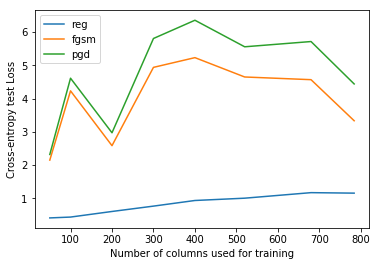

In [78]:
plt.plot(num_cols_lst, lr_lst, label = 'reg')
plt.plot(num_cols_lst, lf_lst, label = 'fgsm')
plt.plot(num_cols_lst, lp_lst, label = 'pgd')
plt.legend()
plt.xlabel("Number of columns used for training")
plt.ylabel("Cross-entropy test Loss")
plt.savefig("/Users/adhyyan/Desktop/loss_vs_nc.pdf", format = 'pdf')

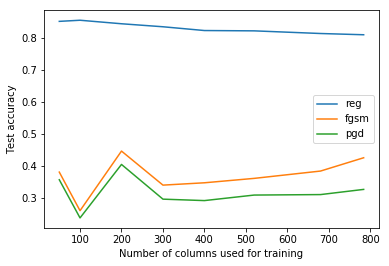

In [79]:
plt.plot(num_cols_lst, ar_lst, label = 'reg')
plt.plot(num_cols_lst, af_lst, label = 'fgsm')
plt.plot(num_cols_lst, ap_lst, label = 'pgd')
plt.legend()
plt.xlabel("Number of columns used for training")
plt.ylabel("Test accuracy")
plt.savefig("/Users/adhyyan/Desktop/acc_vs_nc.pdf", format = 'pdf')

### Random stuff

In [ ]:
x_pgd = x_test_flat + deltas

In [ ]:
x_pgd_2d = x_pgd.reshape((10000, 28, 28))

In [ ]:
np.max(x_pgd_2d)

In [ ]:
x_test[0]

In [ ]:
save_string = "/Users/adhyyan/Desktop/shoe_original_maxV2.pdf"
plt.imshow(x_test[9], cmap = 'Greys')
plt.savefig(save_string, format = 'pdf')
plt.show()

save_string = "/Users/adhyyan/Desktop/shoe_perturbed_maxV2.pdf"
plt.imshow(x_pgd_2d[9], cmap = 'Greys')
plt.savefig(save_string, format = 'pdf')

## Generate data for slave

In [ ]:
with tf.variable_scope(scope_name, reuse = False) as scope:
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((loss_reg, acc_reg))
        
        z_train_slave = model.get_prediction(sess, x_train_slave_flat)
        z_test_slave = model.get_prediction(sess, x_test_flat)

In [ ]:
z_train_slave[0]

# Train slave

In [ ]:
#Setup - Dataset stuff
def slave_training():
    epochs = 20
    lr = 15e-4
    tf.reset_default_graph()
    sess = tf.Session()
    hidden_sizes = [64, 64, 32]
    dataset = ((x_train_slave_flat, z_train_slave), (x_test_flat, y_test))

    scope_name = "teacher_student_fashion"
    if not load_weights:
        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:

            logdir = tensorboard_dir + str(counter)

            #Create model
            writer = tf.summary.FileWriter(logdir)
            model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma, classification = False)
            sess.run(tf.global_variables_initializer())
            print("Created model successfully. Now going to train")

            #Train model
            model.fit(sess, x_train_slave_flat, z_train_slave, training_epochs = epochs, reg_op = reg , lr = lr)

            """
            #Save weights
            weights = tf.trainable_variables()
            #weights = model.get_weights()[0] + model.get_weights()[1]
            saver = tf.train.Saver(weights)
            weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
            print("Saved model at %s"%weights_path)
            """
            loss_real_train, acc_train = model.evaluate(sess, x_train_slave_flat, z_train_slave)

            #Test model - regular, fgsm adv, pgd adv
                        
            loss_class_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            print("----Regular test loss and accuracy ----")
            print((loss_class_reg, acc_reg))
            
            loss_real_reg, acc_real_reg = model.evaluate(sess, x_test_flat, z_test_slave)
            print("----Real test loss and accuracy comparing to teacher ----")
            print((loss_real_reg, acc_real_reg))

            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            print("----FGSM test loss and accuracy ----")
            print((loss_fgsm, acc_fgsm))

            loss_pgd, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
            print("----PGD test loss and accuracy ----")
            print((loss_pgd , acc_pgd))
            
            slave_train_confidences = model.get_prediction(sess, x_train_slave_flat)
            slave_test_confidences = model.get_prediction(sess, x_test_flat)
            
            return loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences
        
        

In [ ]:
tup = slave_training()

In [ ]:
a

In [ ]:
list(tup)

In [ ]:
df = pd.DataFrame()
df['mse on z_train'] = []
df['acc on z_train'] = []
df['mse on z_test'] = []
df['acc on z_test'] = []
df['acc on y_test'] = []

In [ ]:
train_confidences = []
test_confidences = []
for i in range(3):
    loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences = slave_training()
    df.loc[i] = [loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg]
    train_confidences.append(slave_train_confidences)
    test_confidences.append(slave_test_confidences)

In [ ]:
df

In [ ]:
#df.to_excel("ts_fashion_results.xlsx")  